In [24]:
# Install the windpowerlib package.
! pip install windpowerlib
#Import the numpy financial package.
! pip install numpy-financial
    

In [25]:
# importing the library
import pandas as pd
import numpy as np
import math
import scipy.special as sp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy_financial as npf

from windpowerlib import WindTurbine, ModelChain
from windpowerlib import data as wpd

pd.set_option('future.no_silent_downcasting', True)

*Reading the datafile*

In [3]:
#Reading the datafile
df_weather= pd.read_csv('Weather_Montreal.csv', index_col=0, header=[0,1], date_format=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'), parse_dates=True) # Seting the first two rows as header and the first column as index
df_weather = df_weather.copy()
df_weather

variable_name,pressure,temperature,wind_speed,roughness_length,temperature,wind_speed
height,0,2,10,0,10,50
2019-01-01 00:00:00,99760,273.37,7.11,0.15,273.27,9.85
2019-01-01 01:00:00,99480,273.56,6.87,0.15,273.46,10.08
2019-01-01 02:00:00,99200,273.58,6.21,0.15,273.48,9.27
2019-01-01 03:00:00,98910,273.61,3.66,0.15,273.51,6.51
2019-01-01 04:00:00,98760,273.58,1.26,0.15,273.48,2.28
...,...,...,...,...,...,...
2019-12-31 19:00:00,99430,271.17,2.39,0.15,271.07,3.93
2019-12-31 20:00:00,99400,271.35,2.59,0.15,271.25,4.69
2019-12-31 21:00:00,99370,271.69,3.28,0.15,271.59,6.39


In [4]:
df_weather.describe()

variable_name,pressure,temperature,wind_speed,roughness_length,temperature,wind_speed
height,0,2,10,0,10,50
count,8760.000000,8760.000000,8760.000000,8.760000e+03,8760.000000,8760.000000
mean,101105.739726,278.828574,4.430268,1.500000e-01,278.728574,6.349586
std,888.259226,13.340407,2.334118,7.577705e-15,13.340407,3.001052
min,97380.000000,243.330000,0.070000,1.500000e-01,243.230000,0.080000
25%,100530.000000,269.160000,2.870000,1.500000e-01,269.060000,4.270000
50%,101080.000000,279.700000,3.890000,1.500000e-01,279.600000,6.090000
75%,101720.000000,289.790000,5.560000,1.500000e-01,289.690000,8.052500
max,103550.000000,305.410000,18.280000,1.500000e-01,305.310000,23.170000


## Wind Turbine Selection

In [5]:
# Selecting the wind turbine from the windpowerlib data library
wt = wpd.get_turbine_types(print_out=False)
selected_turbine = {'manufacturer': 'Enercon',
                    'turbine_type': 'E48/800',
                    'hub_height': 60}
#Assigned the selected trubine to a variable using the WindTurbine class from windpowerlib
wind_turbine = WindTurbine(**selected_turbine)


### Defining the submodel (Temp, Density, Wind speed)

In [6]:
# definig the submodel(temperature, wind speed, air density)
Turbine_model = {'wind_speed_model': 'hellman',
                 'temperature_model': 'linear_gradient',  # This is the default model for temperature. but can be replaced with other models like the interpolation_extrapolation.
                 'air_density_model': 'barometric',
                 'power_output_model': 'power_coefficient_curve', # the power_curve is the default model
                 'density_correction': True,
                 'hellman_exponent': 0.25,  # This can be adjusted based on the terrain. None means the default value of 0.14 will be used.
                 'obstacle_height': 0.0   # Assuming no obstacles in the area. But this can be set to a value if there are obstacles like buildings or trees.
                 }


In [7]:
# Using the modelchain class to create a model chain
model = ModelChain(wind_turbine, **Turbine_model)
# Running the model chain with the weather data
model = model.run_model(df_weather)

In [8]:
# Calling the power output from the model
df_power_output = model.power_output # by default the power output will be in W but can be converted to kW by dividing by 1000
df_power_output = df_power_output / 1000  # Converting power output to kW
#creating a dataframe with the power output and the time index
df_power_output = pd.DataFrame(df_power_output)
# Displaying the first few rows of the power output dataframe
df_power_output.head()
# renaming the columns for better readability
df_power_output= df_power_output.reset_index()  # Resetting the index to have a clean dataframe
df_power_output.columns = ['Date', 'Power Output (kW)']
df_power_output 

,Date,Power Output (kW)
0,2019-01-01 00:00:00,589.295726
1,2019-01-01 01:00:00,614.168068
2,2019-01-01 02:00:00,495.703319
3,2019-01-01 03:00:00,159.899549
4,2019-01-01 04:00:00,0.874870
...,...,...
8755,2019-12-31 19:00:00,27.051782
8756,2019-12-31 20:00:00,54.062100
8757,2019-12-31 21:00:00,152.597947
8758,2019-12-31 22:00:00,275.509573


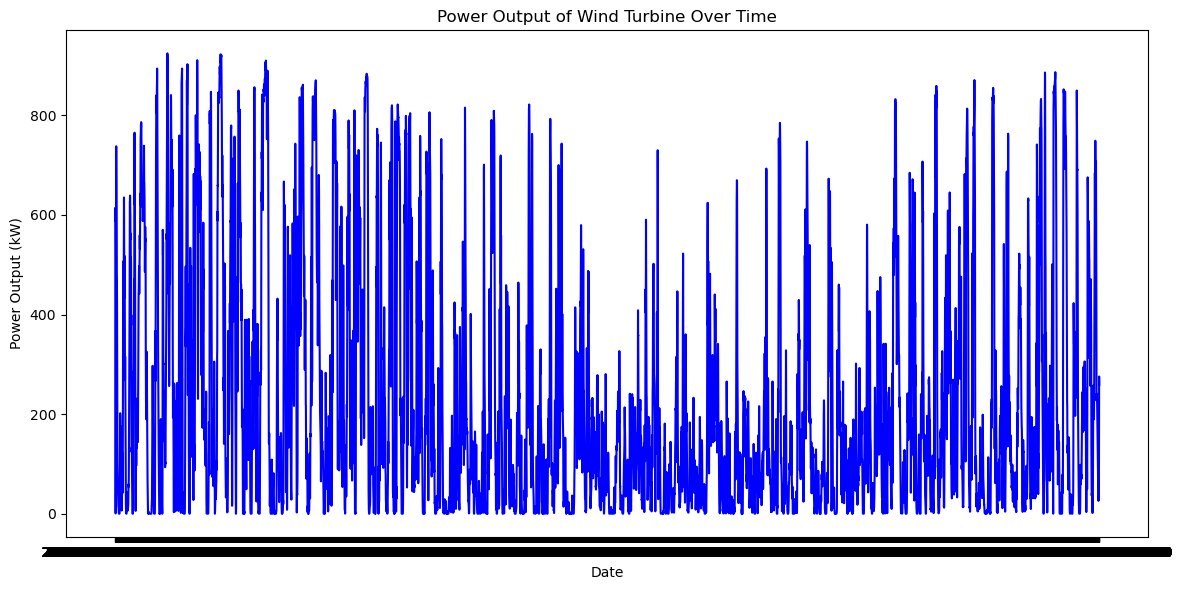

In [9]:
# Plotting the power output
plt.figure(figsize=(12, 6))
sns.lineplot(data= df_power_output,x= 'Date', y= 'Power Output (kW)', color='blue')
plt.title('Power Output of Wind Turbine Over Time')
plt.xlabel('Date')
plt.ylabel('Power Output (kW)')
plt.tight_layout()
plt.show()

## Wind Farm Modeling

In [10]:
# Addtional library packages for the wind farm modeling
from windpowerlib import WindFarm, TurbineClusterModelChain

In [11]:
# Creating a wind turbine fleet with the selected turbine

# wind_turbine_fleet = pd.DataFrame({
#     'wind_turbines': [wind_turbine, None],  # None is used to indicate that the second turbine is not defined]
#     'number_of_turbines': [10, None]  # Assuming only one turbine is defined in the fleet
#     })

# Since we are only interested in the already slected wind turbine, we can create a wind farm with just one turbine
wind_farm_data = {
    'wind_turbine_fleet': [wind_turbine.to_group(10)],  # Assuming we have 10 turbines of the same type
    'efficiency': 0.9  # Assuming an efficiency of 90%

    # 'number_of_turbines': [10],  # Assuming we have 10 turbines of the same type
    # 'turbine_spacing': 5,  # Assuming a spacing of 5 times the rotor diameter
}

# Assigning the wind farm data to a WindFarm class
wind_farm = WindFarm(**wind_farm_data)

In [12]:
# definig the submodel for the wind farm which are 
# the wake effect, smoothing, and turbulance intensity to the already turbine submodels(temperature, wind speed, air density)
Farm_submodel = {
    'wind_speed_model': 'hellman',
    'temperature_model': 'linear_gradient',  # This is the default model for temperature. but can be replaced with other models like the interpolation_extrapolation.
    'air_density_model': 'barometric',
    'power_output_model': 'power_curve', # the power_curve is the default model
    'density_correction': True,
    'hellman_exponent': 0.25,  # This can be adjusted based on the terrain. None means the default value of 0.14 will be used.
    'obstacle_height': 0.0,  # Assuming no obstacles in the area. But this can be set to a value if there are obstacles like buildings or trees.
    'wake_loss_model': 'wind_farm_efficiency',  # metrics or parameters related to wind farm performance, which can be influenced by wake losses.
    'smoothing_model': True,  #  This is used to smooth the power output of the wind farm. It can be set to False if not needed.
    'standard_deviation_method': 'turbulence_intensity'  # This is used to calculate the standard deviation of the wind speed. It can be set to 'turbulence_intensity' or 'standard_deviation'.
    }

In [13]:
# Using the turbineclustermodelchain class to create a model chain
farm_model = TurbineClusterModelChain(wind_farm, **Farm_submodel)
# Running the model chain with the weather data
farm_model = farm_model.run_model(df_weather)

In [14]:
# Calling the power output from the farm model
farm_power_output = farm_model.power_output # by default the power output will be in W but can be converted to kW by dividing by 1000
farm_power_output = farm_power_output / 1000  # Converting power output to kW
#creating a dataframe with the power output and the time index
farm_power_output = pd.DataFrame(farm_power_output)
# Displaying the first few rows of the power output dataframe
farm_power_output.head()
# renaming the columns for better readability
farm_power_output= farm_power_output.reset_index()  # Resetting the index to have a clean dataframe
farm_power_output.columns = ['Date', 'Farm Power Output (kW)']
farm_power_output

,Date,Farm Power Output (kW)
0,2019-01-01 00:00:00,5415.794106
1,2019-01-01 01:00:00,5718.003005
2,2019-01-01 02:00:00,4398.451820
3,2019-01-01 03:00:00,1359.301838
4,2019-01-01 04:00:00,17.702590
...,...,...
8755,2019-12-31 19:00:00,229.785855
8756,2019-12-31 20:00:00,465.671516
8757,2019-12-31 21:00:00,1292.225259
8758,2019-12-31 22:00:00,2396.001705


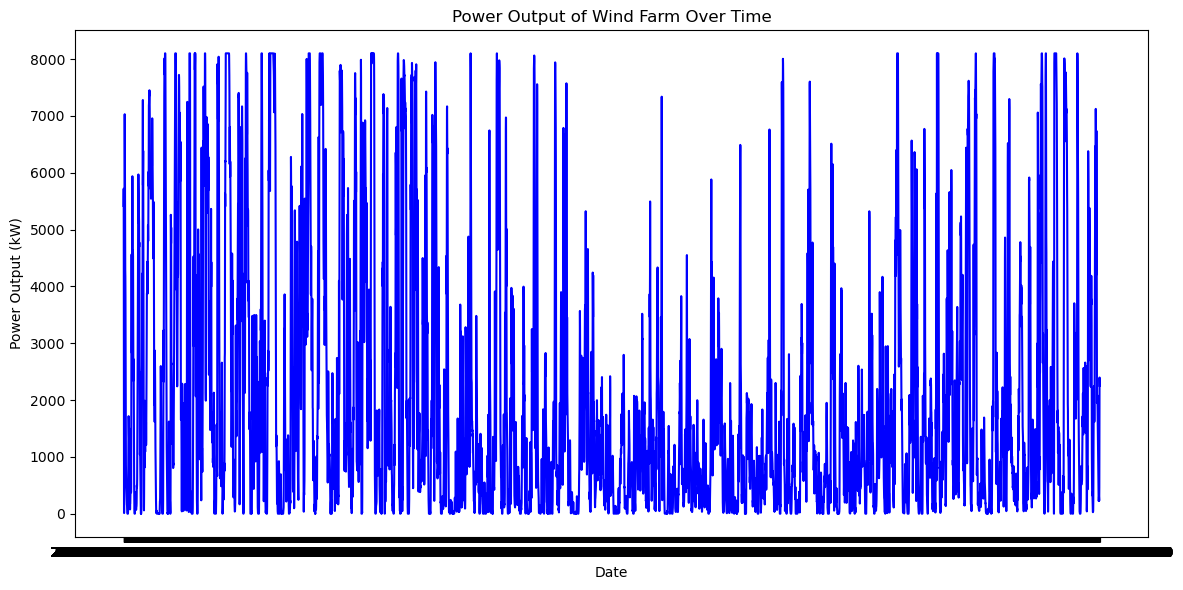

In [15]:
# Plotting the power output
plt.figure(figsize=(12, 6))
sns.lineplot(data= farm_power_output,x= 'Date', y= 'Farm Power Output (kW)', color='blue')
plt.title('Power Output of Wind Farm Over Time')
plt.xlabel('Date')
plt.ylabel('Power Output (kW)')
plt.tight_layout()
plt.show()

In [16]:
merged_df = pd.merge(df_power_output, farm_power_output, on='Date')
merged_df


,Date,Power Output (kW),Farm Power Output (kW)
0,2019-01-01 00:00:00,589.295726,5415.794106
1,2019-01-01 01:00:00,614.168068,5718.003005
2,2019-01-01 02:00:00,495.703319,4398.451820
3,2019-01-01 03:00:00,159.899549,1359.301838
4,2019-01-01 04:00:00,0.874870,17.702590
...,...,...,...
8755,2019-12-31 19:00:00,27.051782,229.785855
8756,2019-12-31 20:00:00,54.062100,465.671516
8757,2019-12-31 21:00:00,152.597947,1292.225259
8758,2019-12-31 22:00:00,275.509573,2396.001705


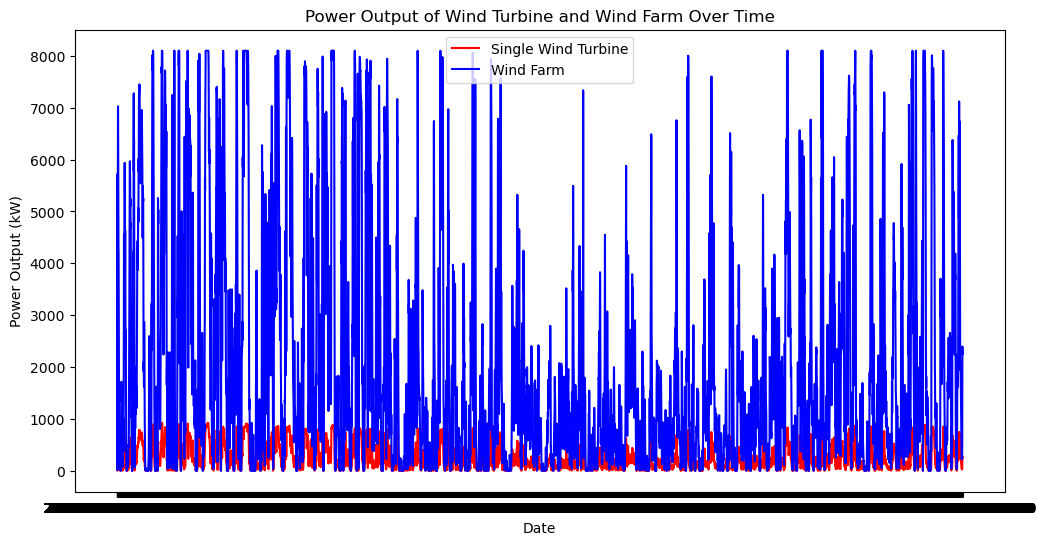

In [17]:
# Plotting the power output of the wind turbine and the wind farm together
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='Date', y='Power Output (kW)', label='Single Wind Turbine', color='red')
sns.lineplot(data=merged_df, x='Date', y='Farm Power Output (kW)', label='Wind Farm', color='blue')
plt.title('Power Output of Wind Turbine and Wind Farm Over Time')
plt.xlabel('Date')
plt.ylabel('Power Output (kW)')
plt.legend()
plt.show()

## Economic Analysis


*The installed capacity from the data is 8000KW based on the 10 turbines installed in the wind farm*
*The Annual energy output will be calculated*
*Assumptions:*
1. CAPEX = $1500 kW
2. OPEX = $50 kW/year
3. Energy Price = $80/MWh
4. Project lifetime = 25 years
5. Discounted Rate = 6%

In [ ]:
# Calculating the annual energy output for the wind farm,
annual_energy_output = merged_df['Farm Power Output (kW)'].sum() * (1/1000)  # Converting kW to MW
annual_energy_output

17360.29084601459

In [19]:
# defining some key parameters for the economic analysis
installed_capacity = 8000 / 1000  # in MW
capital_cost_per_kw = 1500  # in $/kW
operation_and_maintenance_cost_per_kw = 50  # in $/kW/year
energy_price = 80 # in $/MWh
project_lifetime = 20  # in years
discount_rate = 0.07  # 7% discount rate


In [40]:
# Calculating the capital cost of the wind farm
capital_cost = installed_capacity * capital_cost_per_kw * 1000  # in $

# Calculating the annual operation and maintenance cost of the wind farm
annual_om_cost = installed_capacity * operation_and_maintenance_cost_per_kw * 1000  # in $

# Calculating the annual revenue of the wind farm
annual_revenue = annual_energy_output * energy_price  # in $

# Calculating the net  cash flow per year of the wind farm
net_cash_flow = annual_revenue - annual_om_cost  # in $

# Calculating the net present value of the wind farm
npv = npf.npv(discount_rate, [- capital_cost] + [net_cash_flow] * project_lifetime)   # in $

# Calculating the payback period of the wind farm
payback_period = capital_cost / net_cash_flow  # in years

# Calculating the levelized cost of energy (LCOE) of the wind farm
lcoe = (capital_cost + annual_om_cost * project_lifetime) / (annual_energy_output * project_lifetime)  # in $/MWh

In [41]:
# Creating a dataframe to display the economic analysis results
economic_analysis = pd.DataFrame({
    'Metrics': [ 'Capital Cost ($)', 'Annual O&M Cost ($)', 
                  'Annual Revenue ($)', 'Net Cash Flow ($)', 'Net Present Value ($)', 
                  'Payback Period (years)', 'Levelized Cost of Energy ($/MWh)'],
    'Value': [capital_cost, annual_om_cost, annual_revenue, 
              net_cash_flow, npv, payback_period, lcoe]
})
# Displaying the economic analysis results
economic_analysis

,Metrics,Value
0,Capital Cost ($),1.200000e+07
1,Annual O&M Cost ($),4.000000e+05
2,Annual Revenue ($),1.388823e+06
3,Net Cash Flow ($),9.888233e+05
4,Net Present Value ($),-1.524392e+06
5,Payback Period (years),1.213564e+01
6,Levelized Cost of Energy ($/MWh),5.760272e+01


In [42]:
# Formatting the dataframe for better readability
economic_analysis['Value'] = economic_analysis['Value'].apply(lambda x: f"{x:,.2f}" if isinstance(x, (int, float)) else x)
economic_analysis

,Metrics,Value
0,Capital Cost ($),"12,000,000.00"
1,Annual O&M Cost ($),"400,000.00"
2,Annual Revenue ($),"1,388,823.27"
3,Net Cash Flow ($),"988,823.27"
4,Net Present Value ($),"-1,524,392.22"
5,Payback Period (years),12.14
6,Levelized Cost of Energy ($/MWh),57.60
